# Transfer_Learning
Dans la section précédente, nous avons appris qu'au fur et à mesure que le nombre d'images disponibles dans l'ensemble de données d'entraînement augmentait, la précision de classification du modèle continuait d'augmenter, dans la mesure où un ensemble de données d'entraînement comprenant 8 000 images avait une plus grande précision sur l'ensemble de données de validation qu'un ensemble de données d'entraînement. comprenant 1 000 images. Cependant, nous n'avons pas toujours la possibilité d'avoir des centaines ou des milliers d'images, ainsi que les vérités de leurs classes correspondantes, pour entraîner un modèle. C'est là que l'apprentissage par transfert vient à la rescousse.

L'apprentissage par transfert est une technique où nous transférons l'apprentissage du modèle sur un ensemble de données générique vers l'ensemble de données spécifique d'intérêt. En règle générale, les modèles pré-entraînés utilisés pour effectuer l'apprentissage par transfert sont entraînés sur des millions d'images (qui sont génériques et non sur l'ensemble de données qui nous intéresse) et ces modèles pré-entraînés sont désormais ajustés à notre ensemble de données d'intérêt.

Nous allons découvrir deux familles différentes d'architectures d'apprentissage par transfert - les variantes de l'architecture VGG et les variantes de l'architecture ResNet.

En plus de comprendre les architectures, nous comprendrons également leur application dans deux cas d'utilisation différents, la classification par âge et par sexe, où nous apprendrons à optimiser à la fois l'entropie croisée et les pertes d'erreur absolues moyennes en même temps, et la détection des points clés du visage, où nous allons Découvrez comment tirer parti des réseaux de neurones pour générer plusieurs sorties continues (136 au lieu d'une prédiction) dans une seule prédiction. Enfin, nous découvrirons une nouvelle bibliothèque qui aide à réduire considérablement la complexité du code.

## Introducing transfer learning

L'apprentissage par transfert est une technique où les connaissances acquises à partir d'une tâche sont exploitées pour résoudre une autre tâche similaire.

Imaginez un modèle entraîné sur des millions d'images couvrant des milliers de classes d'objets (pas seulement des chats et des chiens). Les différents filtres (noyaux) du modèle s'activeraient pour une grande variété de formes, de couleurs et de textures dans les images. Ces filtres peuvent désormais être réutilisés pour apprendre des fonctionnalités sur un nouvel ensemble d'images. Après l'apprentissage des fonctionnalités, elles peuvent être connectées à une couche cachée avant la couche de classification finale pour la personnalisation sur les nouvelles données.

ImageNet (http://www.image-net.org/) est un concours organisé pour classer environ 14 millions d'images dans 1 000 classes différentes. Il a une variété de classes dans l'ensemble de données, y compris l'éléphant indien, le poisson-lion, le disque dur, la laque pour les cheveux et la jeep.

Les architectures de réseaux de neurones profonds que nous allons parcourir ici ont été formés sur le jeu de données ImageNet. De plus, compte tenu de la variété et du volume d'objets à classer dans ImageNet, les modèles sont très profonds afin de capter le plus d'informations possibles.

Comprenons l'importance de l'apprentissage par transfert à travers un scénario hypothétique:

Considérons une situation où nous travaillons avec des images d'une route, en essayant de les classer en fonction des objets qu'elles contiennent. La construction d'un modèle à partir de zéro peut entraîner des résultats sous-optimaux, car le nombre d'images pourrait être insuffisant pour apprendre les différentes variations au sein de l'ensemble de données (comme nous l'avons vu dans le cas d'utilisation précédent, où la formation sur 8 000 images a entraîné une plus grande précision sur une validation qu'un entraînement sur 2000 images). Un modèle pré-entraîné, formé sur ImageNet, est utile dans un tel scénario. Il aurait déjà beaucoup appris sur les classes liées au trafic, telles que les voitures, les routes, les arbres et les humains, lors de la formation sur le grand ensemble de données ImageNet. Par conséquent, tirer parti du modèle déjà formé entraînerait une formation plus rapide et plus précise que le modèle connaît déjà les formes génériques et doit maintenant les adapter aux images spécifiques. Avec l'intuition en place, comprenons maintenant le flux de haut niveau de l'apprentissage par transfert comme suit:


* 1. Normaliser les images d'entrée, normalisées par la même moyenne et la même déviation standard qui ont été utilisées lors de l'apprentissage du mode pré-entraîné.

* 2. Récupérez l'architecture des modèles pré-entraînés. Récupérer les pondérations de cette architecture résultant de l'entraînement sur un grand ensemble de données

* 3. Enlever les dernières couches du modèle pré-entraîné.

* 4. Connectez le modèle pré-entraîné tronqué à une couche (ou des couches) fraîchement initialisée où les poids sont initialisés de manière aléatoire. Assurez-vous que la sortie de la dernière couche a autant de neurones que les classes/sorties que nous voudrions prédire.

* 5. Assurez-vous que les poids du modèle pré-entraîné ne sont pas entraînables (en d'autres termes, gelés/non mis à jour lors de la rétropropagation), mais que les poids de la couche nouvellement initialisée et les poids connectées à la couche de sortie sont entraînables)

   Nous n'entraînons pas les poids du modèle pré-entraîné, car nous supposons que ces poids sont déjà bien appris pour la tâche, et donc exploitons l'apprentissage d'un grand modèle. En résumé, nous apprenons uniquement les couches nouvellement initialisées pour notre petit jeu de données

* 6. Mettre à jour les paramètres d'apprentissage sur des époques croissantes pour s'adapter à un modèle

Maintenant que nous avons une idée de la façon de mettre en œuvre l'apprentissage par transfert, comprenons les différentes architectures, comment elles sont construites et les résultats lorsque nous appliquons l'apprentissage par transfert au cas d'utilisation des chats par rapport aux chiens dans les sections suivantes. Tout d'abord, nous couvrirons en détail certaines des différentes architectures issues de VGG

## Understanding VGG16 architecture

VGG signifie Visual Geometry Group, qui est basé à l'Université d'Oxford, et 16 signifie le nombre de couches dans le modèle. Le modèle VGG16 est entraîné à classer les objets dans le concours ImageNet et s'est classé deuxième architecture en 2014. La raison pour laquelle nous étudions cette architecture au lieu de l'architecture gagnante (GoogleNet) est sa simplicité et une plus grande acceptation dans la communauté de vision en l'utilisant. dans plusieurs autres tâches. Comprenons l'architecture de VGG16 ainsi que la façon dont un modèle pré-entraîné VGG16 est accessible et représenté dans PyTorch

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

Chargez le modèle VGG16 et enregistrez le modèle dans l'appareil 

In [ ]:
model = models.vgg16(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Dans le code précédent, nous avons appelé la méthode vgg16 au sein de la classe models. De plus, en mentionnant pretrained = True, nous spécifions que nous chargeons les poids qui ont été utilisés pour classer les images dans le concours ImageNet.

Récupérez le résumé du modèle:

In [ ]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,


A noter qu'il y a ~138 millions de paramètres (dont ~122 millions de couches linéaires en bout de réseau – 102 + 16 + 4 millions de paramètres) dans ce réseau, qui comprend 13 couches de convolution et/ou de mutualisation, avec un nombre croissant de filtres et 3 couches linéaires

Une autre façon de comprendre les composants du modèle VGG16 consiste simplement à l'imprimer comme suit :

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Notez qu'il existe trois sous-modules principaux dans le modèle : features, avgpool et classifier. En règle générale, nous gelerions les fonctionnalités et les modules avgpool. Supprimez le module de classification (ou seulement quelques couches en bas) et créez-en un nouveau à sa place qui prédira le nombre requis de classes correspondant à notre ensemble de données (au lieu des 1 000 existants)


Comprenons maintenant comment le modèle VGG16 est utilisé dans la pratique, en utilisant le jeu de données cats versus dogs (en considérant seulement 500 images dans chaque classe pour l'entraînement) dans le code suivant :

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

Téléchargez le jeu de données. Comme nous travaillons sur GoogleColab, nous effectuons les étapes suivantes, où nous fournissons la clé d'authentification et la plaçons dans un emplacement où Kaggle peut utiliser la clé pour nous authentifier et télécharger l'ensemble de données.

In [5]:
from google.colab import files
#files.upload()

In [6]:

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [8]:
#!kaggle datasets download -d tongpython/cat-and-dog
#!unzip cat-and-dog.zip

Spécifiez les dossiers d'images d'entraînement et de test

In [9]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

Fournissez la classe qui renvoie les paires entrée-sortie pour l'ensemble de données chats et chiens. Notez que, dans ce cas, nous récupérons uniquement les 500 premières images de chaque dossier

In [10]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] 
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

Tout en tirant parti des modèles pré-entraînés, il est obligatoire de redimensionner, de permuter, puis de normaliser les images (selon ce qui convient à ce modèle pré-entraîné), où les images sont d'abord mises à l'échelle à une valeur comprise entre 0 et 1 sur les 3 canaux, puis normalisées à une moyenne de [0,485, 0,456, 0,406] et un écart type de [0,229, 0,224, 0,225] sur les canaux RGB

Récupérer les images et leurs étiquettes

In [11]:
data = CatsDogs(train_data_dir)

Inspectons maintenant un exemple d'image et sa classe correspondante :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0')


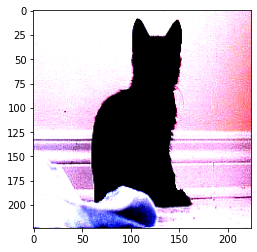

In [12]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

Définir le modèle. Téléchargez les poids VGG16 pré-entraînés, puis figez le module de fonctionnalités et entraînez-vous à l'aide des modules avgpool et classifier :

In [13]:
def get_model():

    # Tout d'abord, nous téléchargeons le modèle VGG16 pré-entraîné à partir de la classe models
    model = models.vgg16(pretrained=True)

    # Précisez que l'on veut figer tous les paramètres dans le modèle téléchargé précédemment
    for param in model.parameters():
        param.requires_grad = False
    # Remplacez le module avgpool pour renvoyer une carte de fonctionnalités de taille 1 x 1 au lieu de 7 x 7, en d'autres termes, la sortie va maintenant être bebatch_size x 512 x 1 x 1
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    # Définir le module classificateur du modèle, où nous aplatissons d'abord la sortie du module avgpool,
    # connectons les 512 unités aux 128 unités et effectuons une activation avant de se connecter à la couche de sortie

    model.classifier = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())

    # Définir la fonction de perte (loss_fn), l'optimiseur et les renvoyer avec le modèle défini
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

Nous avons vu nn.MaxPool2d, où nous choisissons la valeur maximale de chaque section d'une carte de caractéristiques. Il existe une contrepartie à cette couche appelée nn.AvgPool2d, qui renvoie la moyenne d'une section au lieu du maximum. Dans ces deux couches, nous fixons la taille du noyau. La couche ci-dessus, nn.AdaptiveAvgPool2d, est encore une autre couche de Pooling. Nous spécifions à la place la taille de la carte de caractéristiques de sortie. La couche calcule automatiquement les tailles de noyau afin que la taille de carte d'entités spécifiée soit renvoyée. Par exemple, si les dimensions de la taille de la carte des caractéristiques d'entrée étaient batch_size x 512 x kx k, alors la taille du noyau de regroupement sera k x k. Le principal avantage de cette couche est que quelle que soit la taille de l'entrée, la sortie de cette couche est toujours fixe et, par conséquent, le réseau de neurones peut accepter des images de n'importe quelle hauteur et largeur.

Notez que dans le code précédent, nous avons d'abord gelé tous les paramètres du modèle pré-entraîné et avons ensuite écrasé les modules avgpool et classifier. Maintenant, le reste du code va ressembler à ce que nous avons vu dans la section précédente

In [14]:
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, (3,224,224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Entraînez-vous sur un lot de données

In [15]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

Définir une fonction pour calculer la précision sur un lot de données

In [16]:

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

Définir une fonction pour récupérer les chargeurs de données

In [17]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

Initialiser les fonctions get_data et get_model

In [18]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

Entraîner le modèle

In [19]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


Tracez les valeurs de précision d'entraînement et de test sur chaque epoch

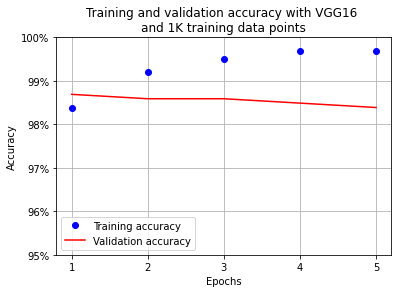

In [20]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()